## Process Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [3]:
# load data
df_cvd = pd.read_csv("./data/data/data_cvd.csv", index_col=0, decimal='.')
df_date = pd.read_csv("date.csv", index_col=0)
df = pd.merge(df_cvd, df_date, left_index=True, right_index=True)
df.convert_dtypes()
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%m/%d/%Y")
df["Data prelievo (1)"] = pd.to_datetime(df["Data prelievo (1)"], format="%m/%d/%Y")
# df.info()

In [4]:
# complete vessels feature
for i in df.index:
    if (pd.isna(df["Vessels"][i]) and df["CAD"][i]==0):
        df.loc[i, "Vessels"] = 0
    elif (pd.isna(df["Vessels"][i]) and df["CAD"][i]==1):
        df.loc[i, "Vessels"] = -1
# df.info()

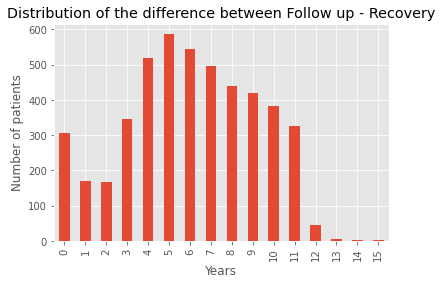

In [5]:
# compute difference between follow up and hospital admission
df_diff = df["Follow Up Data"] - df["Data prelievo (1)"]
for i in df_diff.index:
    df_diff[i] = df_diff[i].days // 365
df_diff.value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of the difference between Follow up - Recovery")
plt.xlabel("Years")
plt.ylabel("Number of patients")

# create the target feature
years = 7
survive = (df_diff < years) & df["CVD Death"]
survive = (survive + 1) % 2

In [6]:
# clean features
# remove dates, follow up features
target = df["CVD Death"]
df_feat = df.iloc[:, :83]
df_feat = pd.concat([df_feat.iloc[:, :30], df_feat.iloc[:, 40:]], axis=1)
df_feat = df_feat.drop(columns=["Patologia TIROIDE ", "Controllo", "Weight", "Height", "Angiography"])
# df_feat.info()

# feature engineering
df_feat["AMI"] = df_feat["Acute \nMyocardial Infarction"] | df_feat["AMI"]
df_feat["PMI"] = df_feat["Previous \nMyocardial Infarction"] | df_feat["PMI"]
df_feat["MIO"] = df_feat["MIN"] | df_feat["MIO"]
df_feat.rename(columns={"MIO": "MIO/MIN"}, inplace=True)
df_feat = df_feat.drop(columns=["MIN", "Previous \nMyocardial Infarction", "Acute \nMyocardial Infarction"])
# df_feat.info()

# TODO drop the features with low percentage?
# df_feat = df_feat.drop(columns=["Low T3", "Normal", "SindromeX", "Miocardite", "Pericardite", "Endocardite", "MalattiaVasoAorta", "CardiopatiaCongenita", "EmboliaPolmonare", "EPA"])

# add target feature
df_feat[f"Survive{years}Y"] = survive

# drop all the remaining na patients
df_feat = df_feat.dropna()
print("Total patient: \t", len(df_feat))
print("Survived: \t", df_feat[f"Survive{years}Y"].sum(), "\t", df_feat[f"Survive{years}Y"].sum()/len(df_feat))
print("Dead: \t\t", len(df_feat)-df_feat[f"Survive{years}Y"].sum(), "\t", (len(df_feat)-df_feat[f"Survive{years}Y"].sum())/len(df_feat))
df_feat.info()

# df_feat.to_csv("data/data/data_cvd_clean.csv")

Total patient: 	 4732
Survived: 	 4378 	 0.9251901944209636
Dead: 		 354 	 0.07480980557903635
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4732 entries, 8986 to 1193
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Age (1)                                     4732 non-null   int64  
 1   Gender (Male = 1)                           4732 non-null   int64  
 2   Angina                                      4732 non-null   int64  
 3   Previous CABG                               4732 non-null   int64  
 4   Previous PCI                                4732 non-null   int64  
 5   Vessels                                     4732 non-null   float64
 6   CAD                                         4732 non-null   int64  
 7   Smoke
History of smoke                      4732 non-null   int64  
 8   Diabetes
History of diabetes                4732 non-null   

In [23]:
# dataset train, valid, test split
import os
def split_and_save(df, path, overwrite=False, verbose=True):
    from sklearn.model_selection import train_test_split
    df_train, df_test = train_test_split(df, test_size=0.2, stratify=df.iloc[:,-1])
    df_train, df_valid = train_test_split(df_train, test_size=0.2, stratify=df_train.iloc[:,-1])

    if len(os.listdir(path)) == 0 or overwrite:
        df_train.to_csv(f"{path}train.csv")
        df_valid.to_csv(f"{path}valid.csv")
        df_test.to_csv(f"{path}test.csv")

    if verbose: 
        print("Train: \t", len(df_train))
        print("Valid: \t", len(df_valid))
        print("Test: \t", len(df_test))

# # save the whole dataset
# split_and_save(df_feat, "data/data/7y/", overwrite=False)

Train: 	 3028
Valid: 	 757
Test: 	 947


## Number of patients for each subgroup
- Angina:         2512
- Aritmie:        1508
- PMI:            1278
- Previous PCI:   650
- Post-ischemic:  478
- AMI:            378 
- Previous CABG:  356

In [22]:
# divide into subgroups and save the datasets
df_angina = df_feat[df_feat["Angina"] == 1]
df_aritmie = df_feat[df_feat["Aritmie"] == 1]
df_pmi = df_feat[df_feat["PMI"] == 1]

split_and_save(df_angina, "data/data/7y/angina/")
split_and_save(df_aritmie, "data/data/7y/aritmie/")
split_and_save(df_pmi, "data/data/7y/pmi/")

Train: 	 1607
Valid: 	 402
Test: 	 503
Train: 	 964
Valid: 	 242
Test: 	 302
Train: 	 817
Valid: 	 205
Test: 	 256


In [165]:
df_test = pd.read_csv("./data/data/7y/train.csv", index_col=0, decimal='.')

# remove all the non frequent (<200) cardio symptoms categories 
df_test = df_test.drop(columns=["Normal", "SindromeX", "Miocardite", "Pericardite", "Endocardite", "MalattiaVasoAorta", "CardiopatiaCongenita", "EmboliaPolmonare", "EPA"])

# remove all the thyroid dychotomy variables obtained from formulas
df_test = df_test.drop(columns=["Euthyroid", "Subclinical primary hypothyroidism (SCH)", "Subclinical primary hyperthyroidism (SCT)", "Low T3", "Ipotiroidismo", "Ipertiroidismo"])

# remove all the patients with vessels = -1, which represent when CAD = 1 and vessels was originally empty
df_test = df_test[df_test["Vessels"] != -1]

df_test.info()

In [25]:
# import seaborn as sns
# fig, ax = plt.subplots(figsize=(35,30))
# sns.heatmap(df_feat.corr(), annot=True)
# fig.savefig("feat.pdf")